In [1]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 

## 데이터 불러오기

In [12]:
DATA_PATH =  "../[01]Data/"
datas = os.listdir(DATA_PATH)
print('CoREMOF_O2_15.0_5760.csv')
O2_15bar = pd.read_csv(os.path.join(DATA_PATH , 'CoREMOF_O2_15.0_5760.csv')).reset_index(drop = True).drop("Unnamed: 0", axis = 1)
O2_15bar  = O2_15bar[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC',  'Uptake']]

CoREMOF_O2_15.0_5760.csv


Index(['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.5bar_GCMC', 'Uptake'],
      dtype='object')

## 액티브 러닝 몬테카를로 드랍아웃
* 10개씩 추가 샘플링해가며 5%부터 학습

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Monte Carlo Dropout 예측 함수
def mc_dropout_predict(model, X, n_simulations):
    model.train()  # 드롭아웃 활성화를 위해 train 모드 유지
    predictions = []
    with torch.no_grad():  # 가중치 업데이트 방지
        for _ in range(n_simulations):
            predictions.append(model(X).detach().numpy())
    
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_prediction, uncertainty

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_5.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
# 'NASA_m2_cm3', 'NASA_m2_g', 'NAV_cm3_g' 제거

X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))  # 데이터셋 인덱스를 랜덤으로 섞음
initial_indices = indices[:initial_size]  # 상위 5% 인덱스 선택
remaining_indices = indices[initial_size:]  # 나머지 인덱스 선택

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices]
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices]
def create_dataloader(X, y, batch_size=32, shuffle=True):
    # y를 numpy 배열로 변환 (필요 시)
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

input_dim = X_train.shape[1]
hidden_dim = 64
# StandardScaler를 초기 데이터에 대해 피팅
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)

# 남은 데이터를 그대로 둠 (추후 transform 적용)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices].to_numpy()

# 초기 데이터 로더 생성
train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 액티브 러닝 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

# 초기 성능 평가
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

# 반복 학습
for iteration in range(iterations):
    # Monte Carlo Dropout 예측
    _, uncertainties = mc_dropout_predict(model, torch.tensor(scaler.transform(X_remaining), dtype=torch.float32), n_simulations=20)
    uncertainties = uncertainties.flatten()

    # 가장 불확실성이 높은 샘플 선택
    most_uncertain_indices = np.argsort(uncertainties)[-samples_per_iteration:]
    sampled_X = X_remaining.iloc[most_uncertain_indices].values
    sampled_y = y_remaining[most_uncertain_indices]

    # 선택된 샘플 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 샘플 제거
    X_remaining = X_remaining.drop(X_remaining.index[most_uncertain_indices]).reset_index(drop=True)
    y_remaining = np.delete(y_remaining, most_uncertain_indices, axis=0)

    # 새 데이터 스케일링 및 로더 생성
    X_initial_scaled = scaler.transform(X_initial)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 최종 성능 기록
print("Performance log:", performance_log)
first_log = performance_log


Initial Test MSE: 0.7675613114165386, R2: -1.0117491505755507


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.04387403264199411, R2: 0.8850078207603185


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.04124408230369656, R2: 0.891900821072387


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.04119958968221144, R2: 0.8920174345495755


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.0314878801056319, R2: 0.9174714578317856


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.027384086559927894, R2: 0.928227345416155


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.026120159862385542, R2: 0.9315400494599245


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.026094516215504224, R2: 0.9316072604879738


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.022758118987043333, R2: 0.9403518313652524


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.02439892535505544, R2: 0.9360513399673528


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.021756604304222882, R2: 0.9429767634488336


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.01990147693498177, R2: 0.9478389820804538


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.020589075984465723, R2: 0.9460368109924099


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.020338318065655638, R2: 0.9466940380082366


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.0206438703051031, R2: 0.9458931971515883


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.019539890810578678, R2: 0.9487866856290932


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.02234346321349212, R2: 0.9414386284560065


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.02132294638784091, R2: 0.9441133644368535


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.021150350832271, R2: 0.944565730856508


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.02231049198287406, R2: 0.9415250448037337


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.02175306709061199, R2: 0.9429860343518498


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.020346468263723168, R2: 0.9466726766475276


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.021377995639602937, R2: 0.9439690824312014


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.02130103052321575, R2: 0.9441708050886789


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.022809202086013093, R2: 0.9402179444959786


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.02356801517141847, R2: 0.9382291241147213


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.02013880028427931, R2: 0.9472169665629181


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.019768224649185387, R2: 0.9481882312788903


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.021917497821742633, R2: 0.942555067628071


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.019620472450928256, R2: 0.9485754841991696


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.021276345747655738, R2: 0.9442355029512813


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.02082078525391218, R2: 0.9454295097657116


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.0195883548131102, R2: 0.9486596633124703


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.01983417038834827, R2: 0.9480153899921139


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.020197564521870888, R2: 0.9470629477199922


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.01868068493634406, R2: 0.9510386317107308


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.019230270240523133, R2: 0.9495981894263084


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.019657431845636883, R2: 0.9484786150242842


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.021387264372027735, R2: 0.9439447894342705


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.018349760467776338, R2: 0.9519059722197477


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.018103507145743186, R2: 0.9525513928578885


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.01926126308587949, R2: 0.9495169583514845


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.01957193177459792, R2: 0.9487027074749177


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.01782613112366929, R2: 0.9532783849150668


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.017971690259804492, R2: 0.9528968799276175


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.017938735014639662, R2: 0.9529832543780767


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.018285984793659085, R2: 0.9520731258481608


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.017815748729568603, R2: 0.9533055967771061


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.019244916331059115, R2: 0.9495598025772622


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.020212896731255744, R2: 0.9470227625794078


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.020449054950264764, R2: 0.9464038008242667


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.02135306854333245, R2: 0.9440344154072159


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.021581215024760982, R2: 0.9434364521130869


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.01969041332521632, R2: 0.948392171814417


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.02277942018518662, R2: 0.9402960017310151


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.021174418339121964, R2: 0.9445026508318328


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.018768738395910374, R2: 0.9508078469253943


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.01734692983782953, R2: 0.954534353350948


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.020005543556371456, R2: 0.9475662274039607


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.018798356075999202, R2: 0.9507302201066966


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.01870676770503513, R2: 0.9509702697610357


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.017398420714522522, R2: 0.9543993977116932


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.020151334635867227, R2: 0.9471841145017408


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.01825686361881811, R2: 0.9521494513453931


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.018612917170293015, R2: 0.9512162484610305


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.01886288964762845, R2: 0.9505610800575856


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.017597369057291035, R2: 0.9538779616340536


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.018957892646480942, R2: 0.95031208079277


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.02027855161190301, R2: 0.9468506836217939


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.01918061738855286, R2: 0.949728327672321


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.01867678423246416, R2: 0.9510488553079866


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.01860163783976871, R2: 0.9512458111594935


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.020585407152991488, R2: 0.9460464268608652


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.01951430805937849, R2: 0.9488537370518667


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.01802443778405728, R2: 0.9527586306626634


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.01981012966319967, R2: 0.9480783998229607


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.019152742792156494, R2: 0.9498013859346238


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.01962025315129315, R2: 0.9485760589752142


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.01816604366767336, R2: 0.9523874870004648


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.017996388336557964, R2: 0.9528321472030903


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.01984043127065787, R2: 0.9479989804565095


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.017648280019326792, R2: 0.9537445259291698


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.018441471300876866, R2: 0.9516656015967834


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.018480048978170516, R2: 0.9515644909644829


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.01778857689647072, R2: 0.9533768131233982


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.017718989382356276, R2: 0.9535591993645077


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.017723344305665533, R2: 0.9535477852753166


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.017478329380677605, R2: 0.9541899601216661


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.01927579846915166, R2: 0.9494788616619874


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.01911300807339287, R2: 0.9499055291288314


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.016152971683867454, R2: 0.9576636724897973


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.01825745489951335, R2: 0.9521479016210666


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.01716242494414545, R2: 0.9550179336951176


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.017155043103740015, R2: 0.955037281219471


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.019282216602855215, R2: 0.9494620399764303


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.018109264457840998, R2: 0.9525363031607528


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.017201589250140217, R2: 0.9549152855311912


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.017527952929394533, R2: 0.9540598986783717


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.019535870036874098, R2: 0.9487972239248157


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.017493198201163615, R2: 0.9541509895058496


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.016323150338295105, R2: 0.9572176406765743
Performance log: [(0.7675613114165386, -1.0117491505755507), (0.04387403264199411, 0.8850078207603185), (0.04124408230369656, 0.891900821072387), (0.04119958968221144, 0.8920174345495755), (0.0314878801056319, 0.9174714578317856), (0.027384086559927894, 0.928227345416155), (0.026120159862385542, 0.9315400494599245), (0.026094516215504224, 0.9316072604879738), (0.022758118987043333, 0.9403518313652524), (0.02439892535505544, 0.9360513399673528), (0.021756604304222882, 0.9429767634488336), (0.01990147693498177, 0.9478389820804538), (0.020589075984465723, 0.9460368109924099), (0.020338318065655638, 0.9466940380082366), (0.0206438703051031, 0.9458931971515883), (0.019539890810578678, 0.9487866856290932), (0.02234346321349212, 0.9414386284560065), (0.02132294638784091, 0.9441133644368535), (0.021150350832271, 0.944565730856508), (0.02231049198287406, 0.9415250448037337), (0.02175306709061199, 0.9429860343518498), (0.

## 랜덤하게 샘플링해서 추가

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_5.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 모델 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 초기 Test 성능 평가
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sample_indices = X_remaining.index[sample_indices]  # 현재 인덱스 동기화
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])
    X_initial_scaled = scaler.transform(X_initial)
    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화


    # 새 학습 데이터로 DataLoader 생성
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 재학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 성능 기록 출력
print("Performance log:", performance_log)
second_log = performance_log


Initial Test MSE: 0.15232410160596968, R2: 0.6007642940569


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.09772985729908734, R2: 0.7438537423877349


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.09250271714586653, R2: 0.757553878919857


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.0837790810613756, R2: 0.7804181989707422


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.06745049330889542, R2: 0.8232148095509801


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.05750744156927574, R2: 0.8492751718878899


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.06848287666502632, R2: 0.8205089718428084


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.06032483170469654, R2: 0.8418908989608027


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.044195935879401994, R2: 0.884164124556783


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.06341415430912846, R2: 0.8337939013231155


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.05480038009819045, R2: 0.8563702775608962


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.07365107376930419, R2: 0.8069633228113973


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.071223902471508, R2: 0.8133248469320327


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.07031243584503287, R2: 0.8157137664676009


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.0765412165780198, R2: 0.7993883678807672


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.06423270094915298, R2: 0.8316485215556846


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.05495113732790878, R2: 0.8559751485668758


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.03464655978608869, R2: 0.9091926779225012


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.057823723102699925, R2: 0.8484462099577549


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.04227593480498956, R2: 0.8891963747146563


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.052641030490027774, R2: 0.8620298511681171


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.038700361683940726, R2: 0.8985678165553294


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.06196425912710676, R2: 0.8375940217271425


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.05007083679822569, R2: 0.8687662315710782


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.0399044992713348, R2: 0.8954118175066729


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.05691927492282901, R2: 0.8508167344103709


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.046995340984537254, R2: 0.8768269897134707


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.05820362306966145, R2: 0.8474505065208163


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.03933682962131249, R2: 0.8968996581771885


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.04727029653569327, R2: 0.8761063416189709


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.044289483011178715, R2: 0.8839189410644789


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.046065417002435875, R2: 0.8792642852796578


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.05572335008007555, R2: 0.8539512081661174


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.04404932985643492, R2: 0.8845483733950015


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.041856444785040775, R2: 0.8902958421822772


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.04165438393466246, R2: 0.8908254360245762


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.04054809129544182, R2: 0.8937249871667942


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.042379636501844405, R2: 0.8889245764915594


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.035449320201233495, R2: 0.9070886732530855


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.04963831449407938, R2: 0.8698998561624031


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.043468431375058875, R2: 0.8860708863318797


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.058279633056426854, R2: 0.8472512872219327


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.04847727441605887, R2: 0.8729428982699206


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.05618490752733734, R2: 0.8527414835634571


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.04585648720377473, R2: 0.8798118823754661


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.06750874709002491, R2: 0.8230621285951243


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.05223061030958862, R2: 0.8631055469296111


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.040769480131676986, R2: 0.8931447354049888


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.039598956659704566, R2: 0.8962126331291764


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.0420460960198069, R2: 0.8897987734728835


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.04584443384931595, R2: 0.8798434737613703


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.03535980702800796, R2: 0.9073232838926831


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.04373134143195297, R2: 0.8853818090220055


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.04923995401326591, R2: 0.8709439439075506


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.06358647777988222, R2: 0.8333422480274676


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.062428727466931414, R2: 0.8363766677852313


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.06513338191412707, R2: 0.8292878708307513


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.046473927674429844, R2: 0.8781935942675376


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.04193549364739587, R2: 0.8900886581054726


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.05130031835061772, R2: 0.8655438069492479


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.04266473333215362, R2: 0.8881773484881731


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.05004077780482189, R2: 0.868845015055274


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.06409032798035685, R2: 0.8320216757191116


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.03923643530466365, R2: 0.8971627878819259


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.05002235473503691, R2: 0.8688933012240003


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.032632643197275844, R2: 0.9144710770895947


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.05177831906134674, R2: 0.8642909851752988


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.05459353655730563, R2: 0.8569124066540225


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.044684044749391076, R2: 0.882884809679934


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.038168913633900355, R2: 0.8999607217830181


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.03769167811764853, R2: 0.9012115380111996


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.055891032615584764, R2: 0.8535117185861195


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.0559272626458088, R2: 0.8534167610479471


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.08215212043768086, R2: 0.7846824011967473


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.03571690781114209, R2: 0.9063873362537718


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.03877593675778239, R2: 0.8983697371467606


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.062156447189617534, R2: 0.8370903040882307


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.07077411687822265, R2: 0.8145037179509003


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.047245716193377585, R2: 0.8761707657659921


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.058027753020431616, R2: 0.8479114552644377


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.06703736292075577, R2: 0.8242976086642954


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.04952894471785793, R2: 0.8701865102070241


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.07165471201031069, R2: 0.8121957114338577


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.04392670765263927, R2: 0.8848697615507859


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.052468574779565756, R2: 0.8624818510590361


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.04625839069290863, R2: 0.878758508539588


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.05485003015723264, R2: 0.8562401466350424


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.061102741938869144, R2: 0.8398520256753154


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.06716882805302993, R2: 0.8239530435276097


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.06650981049020369, R2: 0.8256803036207263


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.07280639222375412, R2: 0.8091772011771934


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.07016838126108123, R2: 0.8160913280807134


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.062026900450350766, R2: 0.8374298411894413


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.06962896717912931, R2: 0.8175051119765857


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.05844370641896727, R2: 0.8468212571477051


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.06826012760671402, R2: 0.8210927886952032


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.05519931042972623, R2: 0.8553246962585703


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.06328090618227017, R2: 0.8341431396211327


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.04854094140583075, R2: 0.8727760294990639


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.055539579280371926, R2: 0.8544328644777441


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.04067013504384306, R2: 0.8934051151207082
Performance log: [(0.15232410160596968, 0.6007642940569), (0.09772985729908734, 0.7438537423877349), (0.09250271714586653, 0.757553878919857), (0.0837790810613756, 0.7804181989707422), (0.06745049330889542, 0.8232148095509801), (0.05750744156927574, 0.8492751718878899), (0.06848287666502632, 0.8205089718428084), (0.06032483170469654, 0.8418908989608027), (0.044195935879401994, 0.884164124556783), (0.06341415430912846, 0.8337939013231155), (0.05480038009819045, 0.8563702775608962), (0.07365107376930419, 0.8069633228113973), (0.071223902471508, 0.8133248469320327), (0.07031243584503287, 0.8157137664676009), (0.0765412165780198, 0.7993883678807672), (0.06423270094915298, 0.8316485215556846), (0.05495113732790878, 0.8559751485668758), (0.03464655978608869, 0.9091926779225012), (0.057823723102699925, 0.8484462099577549), (0.04227593480498956, 0.8891963747146563), (0.052641030490027774, 0.8620298511681171), (0.03870036

## 랜덤 샘플링이면서 매번 아예 새로운 모델을 학습시키는 코드

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_5.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop=True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop=True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
criterion = nn.MSELoss()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)

    # 새 데이터 스케일링
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 새로운 모델 생성
    model = DropoutMLP(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Iteration {iteration + 1}/{iterations} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 성능 기록 출력
print("Performance log:")
for entry in performance_log:
    print(f"MSE: {entry[0]:.4f}, R2: {entry[1]:.4f}")
third_log = performance_log

c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 1/100 - Samples: 240, Test MSE: 0.0560, R2: 0.8533


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 2/100 - Samples: 250, Test MSE: 0.0482, R2: 0.8736


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 3/100 - Samples: 260, Test MSE: 0.0535, R2: 0.8599


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 4/100 - Samples: 270, Test MSE: 0.0481, R2: 0.8740


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 5/100 - Samples: 280, Test MSE: 0.0520, R2: 0.8637


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 6/100 - Samples: 290, Test MSE: 0.0543, R2: 0.8577


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 7/100 - Samples: 300, Test MSE: 0.0477, R2: 0.8750


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 8/100 - Samples: 310, Test MSE: 0.0465, R2: 0.8782


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 9/100 - Samples: 320, Test MSE: 0.0457, R2: 0.8803


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 10/100 - Samples: 330, Test MSE: 0.0431, R2: 0.8871


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 11/100 - Samples: 340, Test MSE: 0.0383, R2: 0.8997


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 12/100 - Samples: 350, Test MSE: 0.0378, R2: 0.9010


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 13/100 - Samples: 360, Test MSE: 0.0421, R2: 0.8897


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 14/100 - Samples: 370, Test MSE: 0.0501, R2: 0.8687


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 15/100 - Samples: 380, Test MSE: 0.0346, R2: 0.9093


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 16/100 - Samples: 390, Test MSE: 0.0367, R2: 0.9038


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 17/100 - Samples: 400, Test MSE: 0.0371, R2: 0.9027


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 18/100 - Samples: 410, Test MSE: 0.0362, R2: 0.9051


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 19/100 - Samples: 420, Test MSE: 0.0325, R2: 0.9149


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 20/100 - Samples: 430, Test MSE: 0.0358, R2: 0.9062


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 21/100 - Samples: 440, Test MSE: 0.0439, R2: 0.8850


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 22/100 - Samples: 450, Test MSE: 0.0510, R2: 0.8664


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 23/100 - Samples: 460, Test MSE: 0.0409, R2: 0.8929


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 24/100 - Samples: 470, Test MSE: 0.0382, R2: 0.8998


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 25/100 - Samples: 480, Test MSE: 0.0361, R2: 0.9054


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 26/100 - Samples: 490, Test MSE: 0.0600, R2: 0.8428


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 27/100 - Samples: 500, Test MSE: 0.0292, R2: 0.9235


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 28/100 - Samples: 510, Test MSE: 0.0383, R2: 0.8996


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 29/100 - Samples: 520, Test MSE: 0.0315, R2: 0.9175


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 30/100 - Samples: 530, Test MSE: 0.0394, R2: 0.8966


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 31/100 - Samples: 540, Test MSE: 0.0327, R2: 0.9143


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 32/100 - Samples: 550, Test MSE: 0.0392, R2: 0.8972


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 33/100 - Samples: 560, Test MSE: 0.0303, R2: 0.9206


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 34/100 - Samples: 570, Test MSE: 0.0430, R2: 0.8874


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 35/100 - Samples: 580, Test MSE: 0.0325, R2: 0.9149


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 36/100 - Samples: 590, Test MSE: 0.0318, R2: 0.9168


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 37/100 - Samples: 600, Test MSE: 0.0374, R2: 0.9021


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 38/100 - Samples: 610, Test MSE: 0.0369, R2: 0.9032


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 39/100 - Samples: 620, Test MSE: 0.0295, R2: 0.9227


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 40/100 - Samples: 630, Test MSE: 0.0322, R2: 0.9157


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 41/100 - Samples: 640, Test MSE: 0.0292, R2: 0.9235


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 42/100 - Samples: 650, Test MSE: 0.0320, R2: 0.9162


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 43/100 - Samples: 660, Test MSE: 0.0402, R2: 0.8947


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 44/100 - Samples: 670, Test MSE: 0.0286, R2: 0.9250


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 45/100 - Samples: 680, Test MSE: 0.0319, R2: 0.9165


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 46/100 - Samples: 690, Test MSE: 0.0330, R2: 0.9134


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 47/100 - Samples: 700, Test MSE: 0.0318, R2: 0.9167


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 48/100 - Samples: 710, Test MSE: 0.0253, R2: 0.9337


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 49/100 - Samples: 720, Test MSE: 0.0321, R2: 0.9159


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 50/100 - Samples: 730, Test MSE: 0.0309, R2: 0.9190


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 51/100 - Samples: 740, Test MSE: 0.0404, R2: 0.8941


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 52/100 - Samples: 750, Test MSE: 0.0233, R2: 0.9390


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 53/100 - Samples: 760, Test MSE: 0.0256, R2: 0.9329


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 54/100 - Samples: 770, Test MSE: 0.0361, R2: 0.9054


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 55/100 - Samples: 780, Test MSE: 0.0246, R2: 0.9355


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 56/100 - Samples: 790, Test MSE: 0.0222, R2: 0.9419


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 57/100 - Samples: 800, Test MSE: 0.0300, R2: 0.9215


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 58/100 - Samples: 810, Test MSE: 0.0254, R2: 0.9333


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 59/100 - Samples: 820, Test MSE: 0.0293, R2: 0.9232


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 60/100 - Samples: 830, Test MSE: 0.0321, R2: 0.9160


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 61/100 - Samples: 840, Test MSE: 0.0362, R2: 0.9051


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 62/100 - Samples: 850, Test MSE: 0.0294, R2: 0.9228


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 63/100 - Samples: 860, Test MSE: 0.0267, R2: 0.9299


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 64/100 - Samples: 870, Test MSE: 0.0352, R2: 0.9078


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 65/100 - Samples: 880, Test MSE: 0.0272, R2: 0.9287


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 66/100 - Samples: 890, Test MSE: 0.0228, R2: 0.9403


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 67/100 - Samples: 900, Test MSE: 0.0350, R2: 0.9082


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 68/100 - Samples: 910, Test MSE: 0.0257, R2: 0.9328


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 69/100 - Samples: 920, Test MSE: 0.0269, R2: 0.9296


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 70/100 - Samples: 930, Test MSE: 0.0285, R2: 0.9253


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 71/100 - Samples: 940, Test MSE: 0.0286, R2: 0.9251


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 72/100 - Samples: 950, Test MSE: 0.0276, R2: 0.9276


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 73/100 - Samples: 960, Test MSE: 0.0226, R2: 0.9406


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 74/100 - Samples: 970, Test MSE: 0.0291, R2: 0.9237


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 75/100 - Samples: 980, Test MSE: 0.0230, R2: 0.9398


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 76/100 - Samples: 990, Test MSE: 0.0304, R2: 0.9202


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 77/100 - Samples: 1000, Test MSE: 0.0257, R2: 0.9325


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 78/100 - Samples: 1010, Test MSE: 0.0267, R2: 0.9299


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 79/100 - Samples: 1020, Test MSE: 0.0205, R2: 0.9462


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 80/100 - Samples: 1030, Test MSE: 0.0306, R2: 0.9197


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 81/100 - Samples: 1040, Test MSE: 0.0270, R2: 0.9293


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 82/100 - Samples: 1050, Test MSE: 0.0316, R2: 0.9172


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 83/100 - Samples: 1060, Test MSE: 0.0322, R2: 0.9156


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 84/100 - Samples: 1070, Test MSE: 0.0317, R2: 0.9169


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 85/100 - Samples: 1080, Test MSE: 0.0265, R2: 0.9305


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 86/100 - Samples: 1090, Test MSE: 0.0376, R2: 0.9014


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 87/100 - Samples: 1100, Test MSE: 0.0369, R2: 0.9033


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 88/100 - Samples: 1110, Test MSE: 0.0298, R2: 0.9219


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 89/100 - Samples: 1120, Test MSE: 0.0284, R2: 0.9256


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 90/100 - Samples: 1130, Test MSE: 0.0327, R2: 0.9143


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 91/100 - Samples: 1140, Test MSE: 0.0284, R2: 0.9257


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 92/100 - Samples: 1150, Test MSE: 0.0317, R2: 0.9168


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 93/100 - Samples: 1160, Test MSE: 0.0273, R2: 0.9285


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 94/100 - Samples: 1170, Test MSE: 0.0372, R2: 0.9024


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 95/100 - Samples: 1180, Test MSE: 0.0337, R2: 0.9117


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 96/100 - Samples: 1190, Test MSE: 0.0226, R2: 0.9409


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 97/100 - Samples: 1200, Test MSE: 0.0254, R2: 0.9333


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 98/100 - Samples: 1210, Test MSE: 0.0291, R2: 0.9236


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 99/100 - Samples: 1220, Test MSE: 0.0257, R2: 0.9327


c:\Users\PSID_PC_20\anaconda3\envs\python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 100/100 - Samples: 1230, Test MSE: 0.0259, R2: 0.9322
Performance log:
MSE: 0.0560, R2: 0.8533
MSE: 0.0482, R2: 0.8736
MSE: 0.0535, R2: 0.8599
MSE: 0.0481, R2: 0.8740
MSE: 0.0520, R2: 0.8637
MSE: 0.0543, R2: 0.8577
MSE: 0.0477, R2: 0.8750
MSE: 0.0465, R2: 0.8782
MSE: 0.0457, R2: 0.8803
MSE: 0.0431, R2: 0.8871
MSE: 0.0383, R2: 0.8997
MSE: 0.0378, R2: 0.9010
MSE: 0.0421, R2: 0.8897
MSE: 0.0501, R2: 0.8687
MSE: 0.0346, R2: 0.9093
MSE: 0.0367, R2: 0.9038
MSE: 0.0371, R2: 0.9027
MSE: 0.0362, R2: 0.9051
MSE: 0.0325, R2: 0.9149
MSE: 0.0358, R2: 0.9062
MSE: 0.0439, R2: 0.8850
MSE: 0.0510, R2: 0.8664
MSE: 0.0409, R2: 0.8929
MSE: 0.0382, R2: 0.8998
MSE: 0.0361, R2: 0.9054
MSE: 0.0600, R2: 0.8428
MSE: 0.0292, R2: 0.9235
MSE: 0.0383, R2: 0.8996
MSE: 0.0315, R2: 0.9175
MSE: 0.0394, R2: 0.8966
MSE: 0.0327, R2: 0.9143
MSE: 0.0392, R2: 0.8972
MSE: 0.0303, R2: 0.9206
MSE: 0.0430, R2: 0.8874
MSE: 0.0325, R2: 0.9149
MSE: 0.0318, R2: 0.9168
MSE: 0.0374, R2: 0.9021
MSE: 0.0369, R2: 0.9032
MSE: 0.

## 랜덤하게 아예 모델 재학습 시키는 경우 높은 샘플링 비율 포인트 찍어서 성능보기

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("../[01]Data/CoREMOF_O2_5.0_5760.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.5bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for i in np.arange(0.3, 1.05, 0.05):
    # Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
    initial_size = int( i* len(X_train))
    indices = np.random.permutation(len(X_train))
    initial_indices = indices[:initial_size]
    remaining_indices = indices[initial_size:]

    X_initial = X_train.iloc[initial_indices]
    y_initial = y_train.iloc[initial_indices].to_numpy()

    # 스탠다드 스케일러 적용
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
    y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

    def create_dataloader(X, y, batch_size=32, shuffle=True):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = create_dataloader(X_initial_scaled, y_initial)
    test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

    # 모델 초기화
    input_dim = X_train.shape[1]
    hidden_dim = 64
    model = DropoutMLP(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 초기 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # 랜덤 샘플링 설정
    iterations = 100
    samples_per_iteration = 10
    performance_log = []

    X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Sample_Fraction {i} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")

train_fractions = np.arange(0.3, 1.05, 0.05)
fourth_log = performance_log

Sample_Fraction 0.3 - Samples: 1382, Test MSE: 0.0212, R2: 0.9444
Sample_Fraction 0.35 - Samples: 1612, Test MSE: 0.0210, R2: 0.9449
Sample_Fraction 0.39999999999999997 - Samples: 1843, Test MSE: 0.0235, R2: 0.9385
Sample_Fraction 0.44999999999999996 - Samples: 2073, Test MSE: 0.0249, R2: 0.9349
Sample_Fraction 0.49999999999999994 - Samples: 2303, Test MSE: 0.0233, R2: 0.9390
Sample_Fraction 0.5499999999999999 - Samples: 2534, Test MSE: 0.0489, R2: 0.8719
Sample_Fraction 0.5999999999999999 - Samples: 2764, Test MSE: 0.0200, R2: 0.9475
Sample_Fraction 0.6499999999999999 - Samples: 2995, Test MSE: 0.0262, R2: 0.9313
Sample_Fraction 0.7 - Samples: 3225, Test MSE: 0.0204, R2: 0.9466
Sample_Fraction 0.7499999999999999 - Samples: 3455, Test MSE: 0.0186, R2: 0.9512
Sample_Fraction 0.7999999999999998 - Samples: 3686, Test MSE: 0.0212, R2: 0.9443
Sample_Fraction 0.8499999999999999 - Samples: 3916, Test MSE: 0.0165, R2: 0.9567
Sample_Fraction 0.8999999999999999 - Samples: 4147, Test MSE: 0.0200,

In [7]:
ls = []
for a , b, c in zip(first_log, second_log , third_log):
    dic = {}
    for i, co in zip(list(a) + list(b) + list(c) , ["Active_Learning_MSE" , "Active_Learning_R2", "Random_이어서학습_MSE", "Random_이어서학습_R2", "Random_모델재학습_MSE", "Random_모델재학습_R2"]):
        dic[co] = i 
    ls.append(dic)
# pd.DataFrame(ls).to_csv("Active_Learning_O2_5bar_Score.csv")
pd.DataFrame(ls)

,Active_Learning_MSE,Active_Learning_R2,Random_이어서학습_MSE,Random_이어서학습_R2,Random_모델재학습_MSE,Random_모델재학습_R2
0,0.767561,-1.011749,0.147045,0.614599,0.141914,0.628049
1,0.043874,0.885008,0.130360,0.658332,0.125277,0.671654
2,0.041244,0.891901,0.115399,0.697544,0.113412,0.702751
3,0.041200,0.892017,0.094535,0.752229,0.089269,0.766030
4,0.031488,0.917471,0.104181,0.726946,0.084754,0.777864
...,...,...,...,...,...,...
95,0.018109,0.952536,0.051868,0.864055,0.030165,0.920938
96,0.017202,0.954915,0.045907,0.879680,0.024814,0.934963
97,0.017528,0.954060,0.062666,0.835756,0.027135,0.928881
98,0.019536,0.948797,0.069115,0.818852,0.021369,0.943993


In [ ]:
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864

In [ ]:
0.9444,0.9449,0.9385,0.9349,0.9390,0.8719,0.9475,0.9313,0.9466,0.9512,0.9443,0.9567,0.9475,0.9397,0.9524

## 전체 Train셋에 대한 퍼센트로 X축을 구성해서 비교 시각화

(0.5, 1.0)

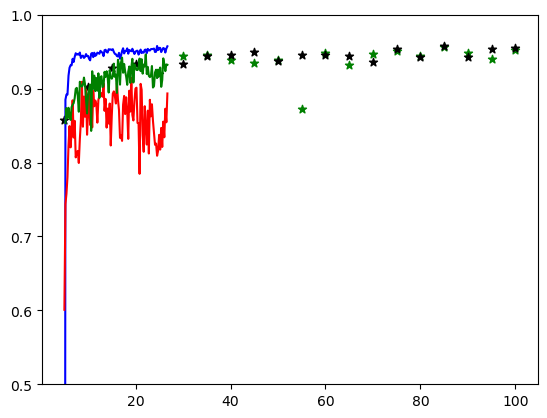

In [19]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
plt.ylim(0.5,1)
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100, [0.9444,0.9449,0.9385,0.9349,0.9390,0.8719,0.9475,0.9313,0.9466,0.9512,0.9443,0.9567,0.9475,0.9397,0.9524]  , marker = "*" , color = "green")
catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8571,0.9022,0.9278,0.9329,0.9197,0.9331,0.9445,0.9461,0.9500,0.9367,0.9460,0.9448,0.9447,0.9355,0.9536,0.9430,0.9570,0.9426,0.9530,0.9548]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.5,1)


(0.8, 1.0)

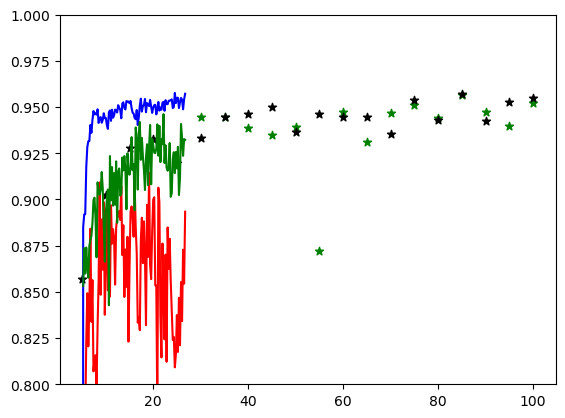

In [21]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
plt.ylim(0.8,1)
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100, [0.9444,0.9449,0.9385,0.9349,0.9390,0.8719,0.9475,0.9313,0.9466,0.9512,0.9443,0.9567,0.9475,0.9397,0.9524]  , marker = "*" , color = "green")
catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8571,0.9022,0.9278,0.9329,0.9197,0.9331,0.9445,0.9461,0.9500,0.9367,0.9460,0.9448,0.9447,0.9355,0.9536,0.9430,0.9570,0.9426,0.9530,0.9548]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.8,1)


* 확대

(0.8, 1.0)

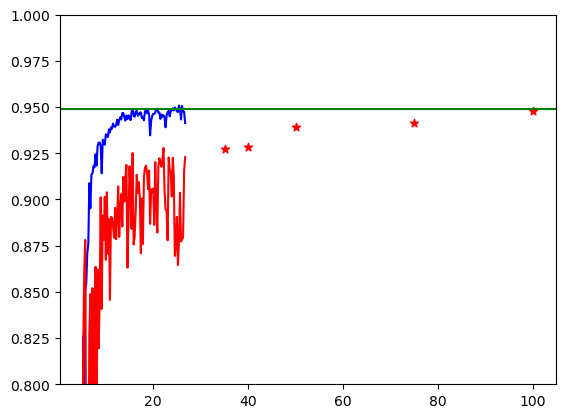

In [109]:
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  first_performance_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  second_performance_log] , color = "red" )
# plt.axhline(0.94)
plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )

plt.axhline(y  =max( [ x[1] for x in  first_performance_log]) - 0.002, color = 'green')
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.80, 1)